In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
df = air_quality.data.features

# Remove 'Date' and 'Time' columns
df = df.drop(columns=['Date', 'Time'])

Correlations with the target (NO2(GT)):
CO(GT)           0.661065
PT08.S1(CO)      0.618377
NMHC(GT)         0.162060
C6H6(GT)         0.592298
PT08.S2(NMHC)    0.622923
NOx(GT)          0.763111
PT08.S3(NOx)    -0.628550
NO2(GT)          1.000000
PT08.S4(NO2)     0.151681
PT08.S5(O3)      0.682572
T               -0.179801
RH              -0.088447
AH              -0.322931
Name: NO2(GT), dtype: float64


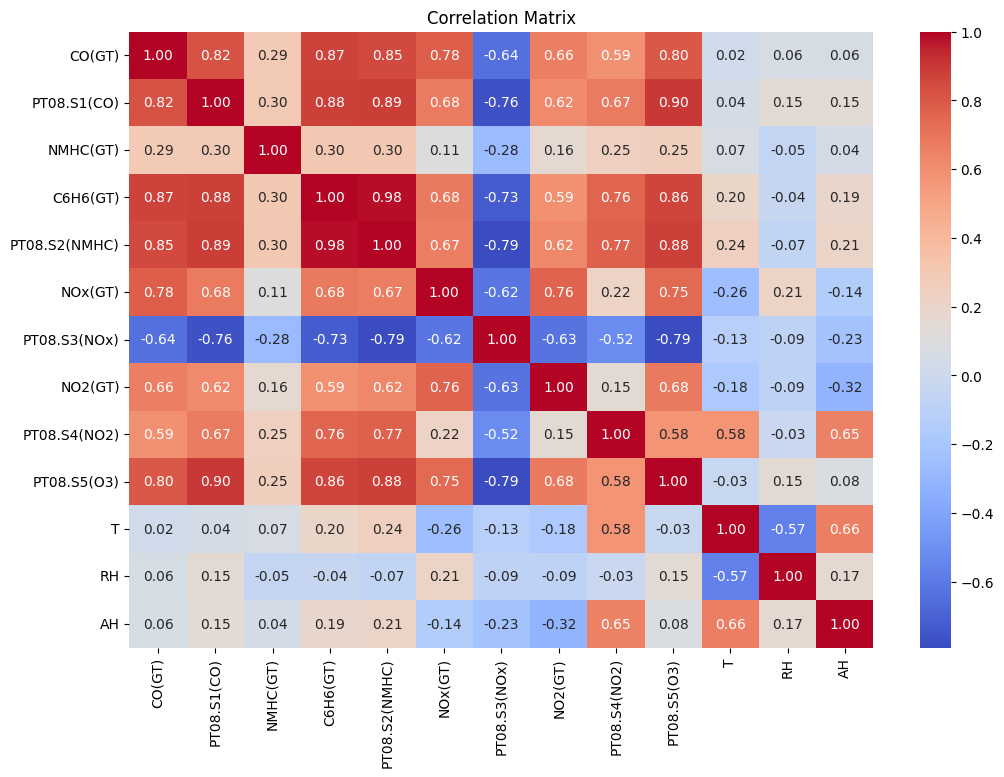

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is already preprocessed (e.g., -200 replaced with NaN)

# Drop rows with missing target values
df = df.dropna(subset=['NO2(GT)'])

# Replace missing values (-200 replaced earlier with NaN)
df = df.fillna(df.mean())

# Calculate correlation matrix
correlation_matrix = df.corr()

# Extract correlations with the target
correlations_with_target = correlation_matrix['NO2(GT)']

# Print each correlation with the target
print("Correlations with the target (NO2(GT)):")
print(correlations_with_target)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Features identified as "useless"
useless_features = ['NMHC(GT)', 'T', 'RH', 'NMHC(GT)','PT08.S4(NO2)']

# Drop the useless features
X = df.drop(columns=useless_features + ['NO2(GT)'])  # Remove from features
y = df['NO2(GT)']

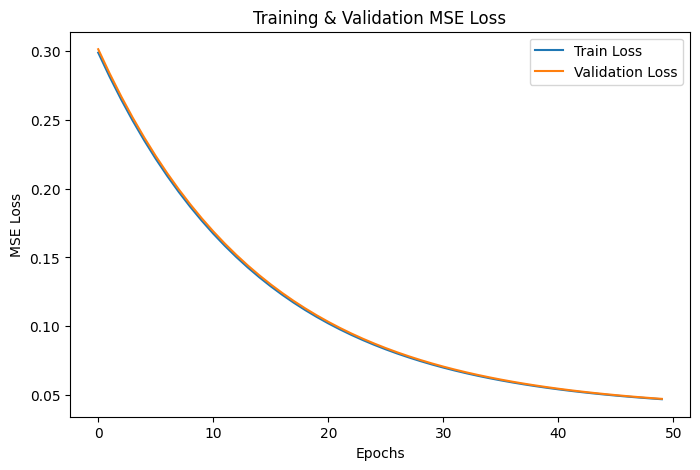

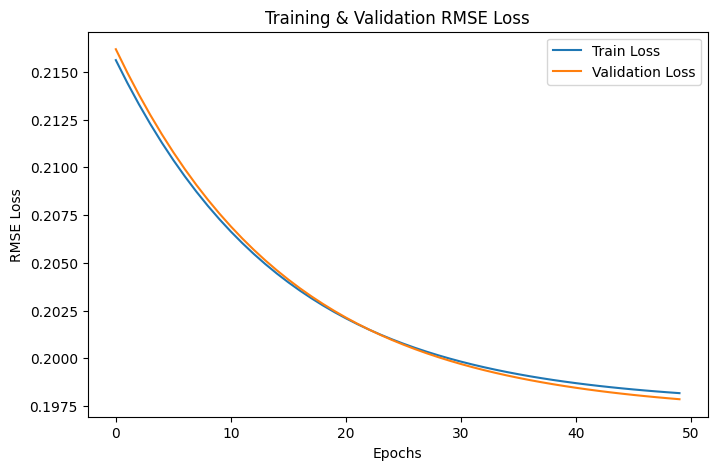

Test MSE Loss: 0.03369289501820773
Test RMSE Loss: 0.18355624483576616


In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Define the RBFNetwork class (already provided in your code)
class RBFNetwork:
    def __init__(self, input_size, hidden_size, output_size, sigma=1.0, lr=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sigma = sigma
        self.lr = lr

        self.centers = np.random.randn(hidden_size, input_size)
        self.weights = np.random.randn(hidden_size, output_size)

    def rbf_activation(self, X):
        N = X.shape[0]
        rbf_outputs = np.zeros((N, self.hidden_size))
        for i in range(self.hidden_size):
            diff = X - self.centers[i]
            dist_sq = np.sum(diff ** 2, axis=1)
            rbf_outputs[:, i] = np.exp(-dist_sq / (2 * (self.sigma ** 2)))
        return rbf_outputs

    def forward(self, X):
        hidden_output = self.rbf_activation(X)
        output = hidden_output.dot(self.weights)
        return output, hidden_output

    def compute_loss_mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def compute_loss_rmse(self, y_true, y_pred):
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

    def backward(self, X, y_true, y_pred, hidden_output):
        if y_pred.ndim == 2 and y_pred.shape[1] == 1:
            y_pred = y_pred.ravel()
        if y_true.ndim == 2 and y_true.shape[1] == 1:
            y_true = y_true.ravel()

        N = X.shape[0]
        error = (y_true - y_pred)

        dW = -(2.0 / N) * hidden_output.T.dot(error[:, np.newaxis])
        self.weights -= self.lr * dW

        dL_dCenters = np.zeros_like(self.centers)
        for i in range(self.hidden_size):
            diff = X - self.centers[i]
            dist_sq = np.sum(diff ** 2, axis=1)
            rbf_vals = np.exp(-dist_sq / (2 * self.sigma ** 2))
            grad_center = np.zeros(self.input_size)
            for n in range(N):
                grad_center += error[n] * rbf_vals[n] * diff[n] / (self.sigma ** 2)
            grad_center *= -(2.0 / N)
            dL_dCenters[i] = grad_center
        self.centers -= self.lr * dL_dCenters

    def train_mse(self, X_train, y_train, X_val, y_val, epochs=50):
        train_losses_mse = []
        val_losses_mse = []
        for epoch in range(epochs):
            y_train_pred, hidden_train = self.forward(X_train)
            y_val_pred, _ = self.forward(X_val)

            train_loss = self.compute_loss_mse(y_train, y_train_pred)
            val_loss = self.compute_loss_mse(y_val, y_val_pred)

            train_losses_mse.append(train_loss)
            val_losses_mse.append(val_loss)

            self.backward(X_train, y_train, y_train_pred, hidden_train)

        return train_losses_mse, val_losses_mse


    def train_rmse(self, X_train, y_train, X_val, y_val, epochs=50):
        train_losses_rmse = []
        val_losses_rmse = []
        for epoch in range(epochs):
            y_train_pred, hidden_train = self.forward(X_train)
            y_val_pred, _ = self.forward(X_val)

            train_loss = self.compute_loss_rmse(y_train, y_train_pred)
            val_loss = self.compute_loss_rmse(y_val, y_val_pred)

            train_losses_rmse.append(train_loss)
            val_losses_rmse.append(val_loss)

            self.backward(X_train, y_train, y_train_pred, hidden_train)

        return train_losses_rmse, val_losses_rmse


if __name__ == "__main__":
    # Fetch the dataset
    air_quality = fetch_ucirepo(id=360)
    df = air_quality.data.features

    # Remove 'Date' and 'Time' columns
    df = df.drop(columns=['Date', 'Time'])

    # Replace missing values (-200) with NaN
    df.replace(-200, np.nan, inplace=True)

    # Set NO2(GT) as the target column
    target = df['NO2(GT)']
    features = df.drop(columns=['NO2(GT)'])

    # Drop useless features
    useless_features = ['NMHC(GT)', 'T', 'RH', 'PT08.S4(NO2)']
    X = features.drop(columns=useless_features)
    y = target

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Scale the features
    X_scaled = scaler.fit_transform(X)

    # Reshape and scale the target
    y = y.values.reshape(-1, 1) if isinstance(y, pd.Series) else y.reshape(-1, 1)
    y_scaled = scaler.fit_transform(y)

    X_scaled = np.nan_to_num(X_scaled)
    y_scaled = np.nan_to_num(y_scaled)

    # Train-test-validation split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Initialize the RBF Network
    rbf_model = RBFNetwork(input_size=X_train.shape[1], hidden_size=3, output_size=1, sigma=4, lr=0.01)

    # Train the model
    train_losses_mse, val_losses_mse = rbf_model.train_mse(X_train, y_train, X_val, y_val, epochs=50)
    train_losses_rmse, val_losses_rmse = rbf_model.train_rmse(X_train, y_train, X_val, y_val, epochs=50)

    # Plot training and validation losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses_mse, label="Train Loss")
    plt.plot(val_losses_mse, label="Validation Loss")
    plt.title("Training & Validation MSE Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    # Plot training and validation losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses_rmse, label="Train Loss")
    plt.plot(val_losses_rmse, label="Validation Loss")
    plt.title("Training & Validation RMSE Loss")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE Loss")
    plt.legend()
    plt.show()


    # Evaluate on test set
    y_test_pred, _ = rbf_model.forward(X_test)
    y_test_pred = y_test_pred.ravel() if y_test_pred.ndim == 2 else y_test_pred
    test_loss_mse = rbf_model.compute_loss_mse(y_test, y_test_pred)
    test_loss_rmse = rbf_model.compute_loss_rmse(y_test, y_test_pred)

    print("Test MSE Loss:", test_loss_mse)
    print("Test RMSE Loss:", test_loss_rmse)

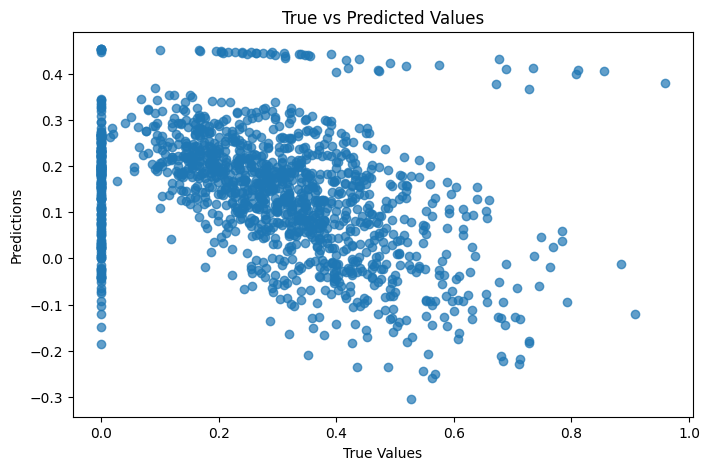

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()